In [2]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 4.1 MB/s eta 0:00:00a 0:00:01
  Using cached kiwisolver-1.4.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 16.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.0/306.0 kB 5.8 MB/s eta 0:00:00ta 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 18.7 MB/s eta 0:00:0000:0100:01
Using cached kiwisolver-1.4.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.4 MB)


In [3]:
!pip install pandas

In [2]:
from CodeGraphDataset_diversevul_erik_preprocessed import CodeGraphDataset
from torch_geometric.data import DataLoader
import torch 
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

/home/amos/mambaforge/envs/pyg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [58]:
def num_nodes(adj, x, threshold, numn):
    return numn

def avg_degree(adj, x, threshold,numn):
    return torch.mean(torch.sum(adj, dim=2), dim=1)

def avg_triangle_counts(adj, x, threshold,numn):
    return torch.mean(x[:, :, 17], dim=1)  

dict_ = {
    # 'num_nodes': {'predictor':num_nodes,'threshold_range':[0,2000,1]} ,
    'avg_degree': {'predictor':avg_degree,'threshold_range':[0,1000,1, 0.05]} ,
    # 'avg_triangle_counts': {'predictor':avg_triangle_counts,'threshold_range':[0,25,1]}
}

def calc_metrics(y, y_hat):
    TP = torch.sum(y*y_hat)
    FP = torch.sum((1-y)*y_hat)
    FN = torch.sum(y*(1-y_hat))
    TN = torch.sum((1-y)*(1-y_hat))
    
    # check no zeros in denominator
    precision = TP/(TP+FP) if TP+FP != 0 else 0
    recall = TP/(TP+FN) if TP+FN != 0 else 0
    f1 = 2*(precision*recall)/(precision+recall) if precision+recall != 0 else 0
    balanced_accuracy = 0.5*(TP/(TP+FN) + TN/(TN+FP))
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    TOTAL = TP+FP+FN+TN
    return TOTAL, TP, FP, FN, TN, precision, recall, f1, balanced_accuracy, accuracy

import os 
import pandas as pd
# make threhold folder
if not os.path.exists('thresholds'):
    os.makedirs('thresholds')
    
data = [] 
for metric_name, metric in dict_.items():
    
    for i in range(5):
        precomputed_metric, ys = [],[]
        val_dataset = CodeGraphDataset(pt_folder='codegraphs/diversevul/v2_undirected_withdegreecount', DS_type = 'larger10smaller1000', split='val', cross_val_valfold_idx=i, is_cross_val=True is not None, cross_val_val_fraction=1
                        ,remove_degreeandtriangles=False, dense_mode=True)
        loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        for minibatch in tqdm(loader):
            # print(minibatch)
            adj, x,y,numnd = minibatch.adj, minibatch.x, minibatch.y, minibatch.numnodes
            precomputed_y_hat = metric['predictor'](adj, x, threshold, numnd)
            precomputed_metric.append(precomputed_y_hat.to(torch.int))
            ys.append(y)
            
        
        ys = torch.cat(ys)
        precomputed_metric = torch.cat(precomputed_metric)
        
        for threshold in range(metric['threshold_range'][0], metric['threshold_range'][1], metric['threshold_range'][2]):
            if len(metric['threshold_range']) == 4:
                threshold = threshold * metric['threshold_range'][3]
                
            # if not os.path.exists(f'thresholds/{metric_name}'):
            #     # make dir 
            #     os.makedirs(f'thresholds/{metric_name}')
            # if not os.path.exists(f'thresholds/{metric_name}/data.csv'):
            #     # make df
            #     df = pd.DataFrame(columns=['threshold', 'min_threshold','max_threshold','fold', 'TOTAL', 'TP', 'FP', 'FN', 'TN', 'precision', 'recall', 'f1', 'balanced_accuracy', 'accuracy'])
            # else: 
            #     df = pd.read_csv(f'thresholds/{metric_name}/data.csv')
                
            # for i in range(5):
                
                
            #     y_hats, ys = [], []
            #     for minibatch in tqdm(loader):
            #         # print(minibatch)
            #         adj, x,y,numnd = minibatch.adj, minibatch.x, minibatch.y, minibatch.numnodes
            #         y_hat = metric['predictor'](adj, x, threshold, numnd)
            #         # y_hat = model(adj, x, threshold)
            #         y_hats.append(y_hat)
            #         ys.append(y)
                
            #     y = torch.cat(ys)
            #     y_hat = torch.cat(y_hats)
            #     y_hat = y_hat.to(torch.int)
            y_hat = precomputed_metric > threshold
            y_hat = y_hat.to(torch.int)
            TOTAL, TP, FP, FN, TN, precision, recall, f1, balanced_accuracy, accuracy = calc_metrics(ys, y_hat)
            TOTAL = TOTAL.item()
            TP, FP, FN, TN = TP.item(), FP.item(), FN.item(), TN.item()
            
            
            precision, recall, f1, balanced_accuracy, accuracy = precision, recall, f1, balanced_accuracy.item(), accuracy.item()
            
            if type(precision) == torch.Tensor:
                precision = precision.item()
            if type(recall) == torch.Tensor:
                recall = recall.item()
            if type(f1) == torch.Tensor:
                f1 = f1.item()
            
            # add to df
            # data.append({'threshold' : threshold, 'min_threshold':metric['threshold_range'][0],'max_threshold':metric['threshold_range'][1],'fold':i, 'TOTAL':TOTAL, 'TP':TP, 'FP':FP, 'FN':FN, 'TN':TN, 'precision':precision, 'recall':recall, 'f1':f1, 'balanced_accuracy':balanced_accuracy, 'accuracy':accuracy})
            data.append([metric_name,threshold,metric['threshold_range'][0],metric['threshold_range'][1],i,TOTAL,TP,FP,FN,TN,precision,recall,f1,balanced_accuracy,accuracy])
            
        # save df
        # df.to_csv(f'thresholds/{metric_name}/data.csv', index=False)
        
df = pd.DataFrame(data, columns=['metric_name','threshold', 'min_threshold','max_threshold','fold', 'TOTAL', 'TP', 'FP', 'FN', 'TN', 'precision', 'recall', 'f1', 'balanced_accuracy', 'accuracy'])
df.to_csv(f'thresholds/dataavgdegreee.csv', index=False)


Split 0: 31514
Split 1: 37095
Split 2: 62861
Split 3: 44591
Split 4: 28496


Processing...
Done!
/home/amos/mambaforge/envs/pyg/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|██████████| 985/985 [01:41<00:00,  9.72it/s]


Split 0: 31514
Split 1: 37095
Split 2: 62861
Split 3: 44591
Split 4: 28496


Processing...
Done!
100%|██████████| 1160/1160 [01:57<00:00,  9.83it/s]


Split 0: 31514
Split 1: 37095
Split 2: 62861
Split 3: 44591
Split 4: 28496


Processing...
Done!
100%|██████████| 1965/1965 [03:45<00:00,  8.70it/s]


Split 0: 31514
Split 1: 37095
Split 2: 62861
Split 3: 44591
Split 4: 28496


Processing...
Done!
100%|██████████| 1394/1394 [02:31<00:00,  9.23it/s]


Split 0: 31514
Split 1: 37095
Split 2: 62861
Split 3: 44591
Split 4: 28496


Processing...
Done!
100%|██████████| 891/891 [02:11<00:00,  6.77it/s]


In [44]:
metric_name

'avg_degree'

In [33]:
precomputed_y_hat

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])

In [22]:
y_hat

tensor([0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)

In [31]:
precomputed_y_hat

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])

In [37]:
metric

{'predictor': <function __main__.num_nodes(adj, x, threshold, numn)>,
 'threshold_range': [0, 2000, 20]}

In [48]:
# std across folds:
dataset = pd.read_csv('thresholds/data.csv')

In [51]:
# group by metric name, get the mean across all fold for each threshold
grouped = dataset.groupby(['metric_name','threshold']).mean()
# get std
grouped_std = dataset.groupby(['metric_name','threshold']).std()

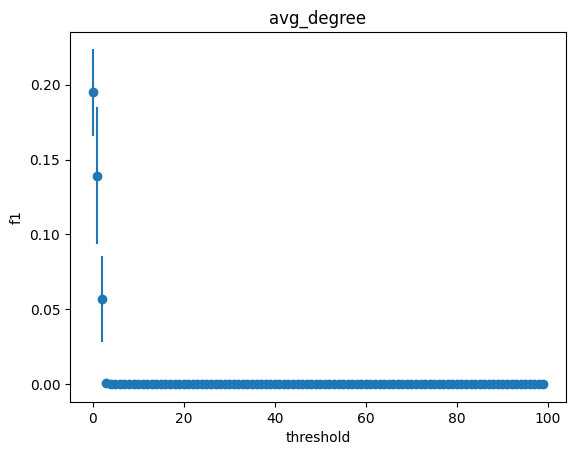

avg_degree best threshold: 0 best f1: 0.19475986957550045


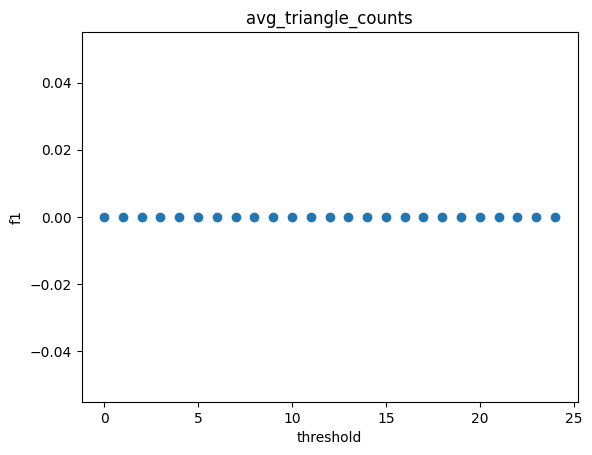

avg_triangle_counts best threshold: 0 best f1: 0.0


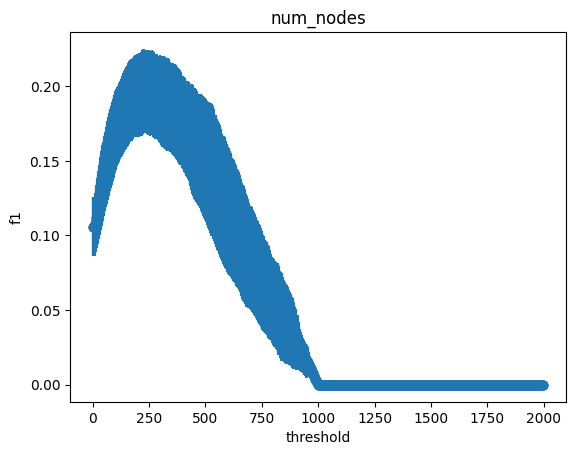

num_nodes best threshold: 227 best f1: 0.19697565436363215


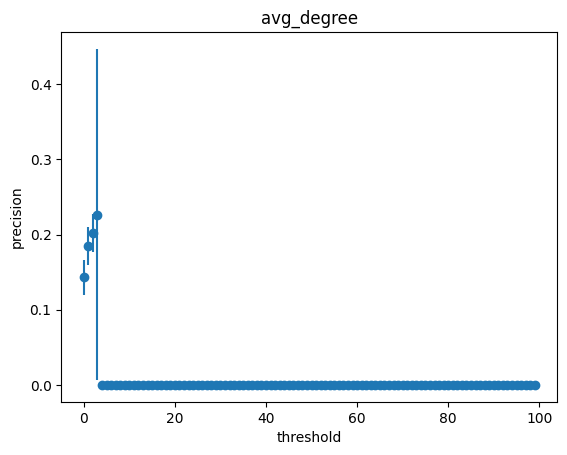

avg_degree best threshold: 3 best precision: 0.22666667103767396


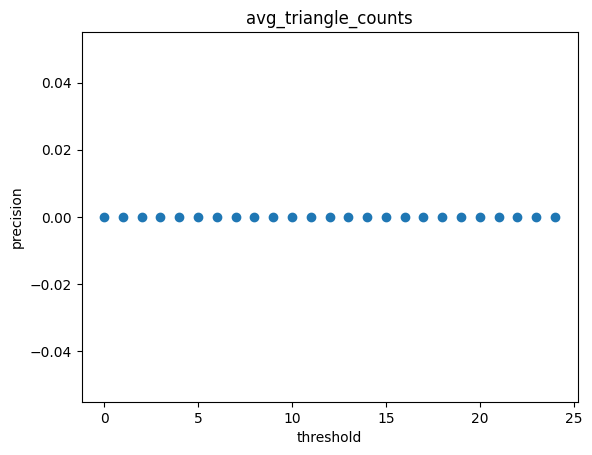

avg_triangle_counts best threshold: 0 best precision: 0.0


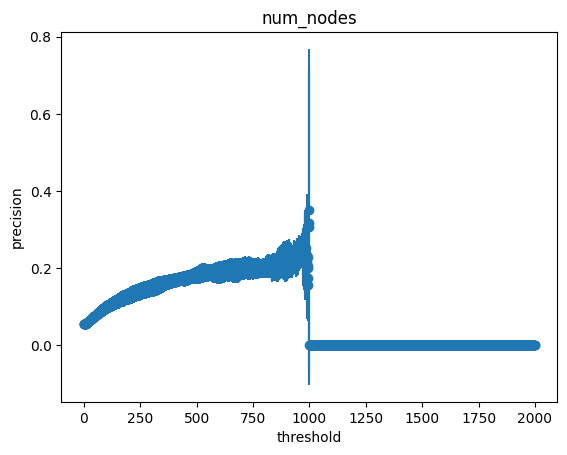

num_nodes best threshold: 999 best precision: 0.35


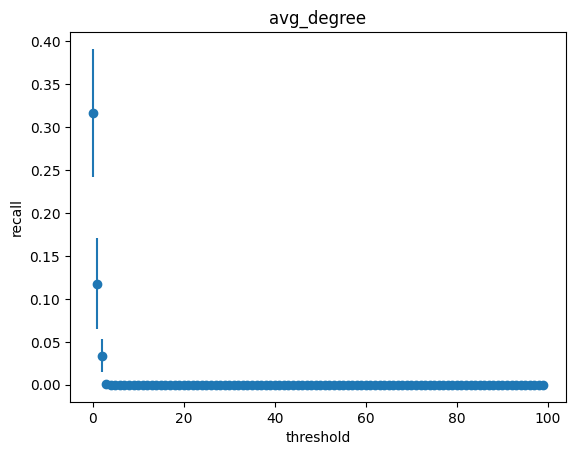

avg_degree best threshold: 0 best recall: 0.3161026298999786


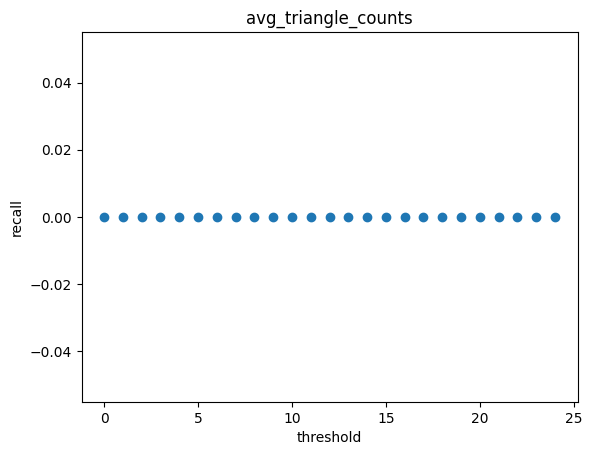

avg_triangle_counts best threshold: 0 best recall: 0.0


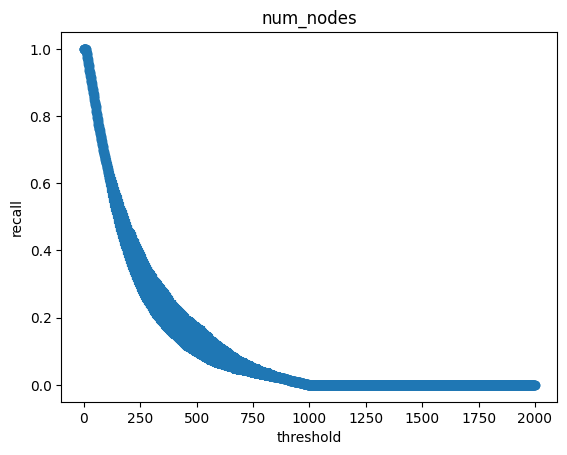

num_nodes best threshold: 0 best recall: 1.0


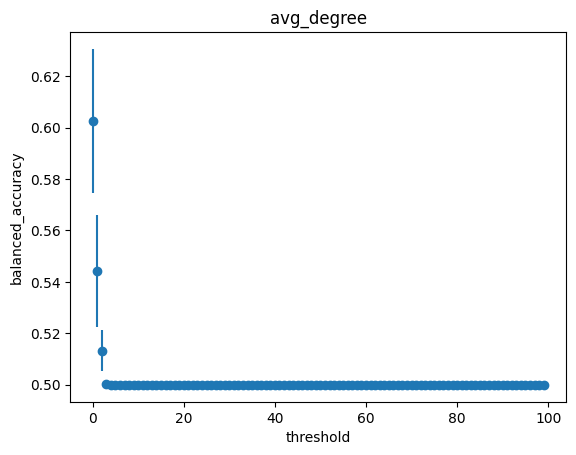

avg_degree best threshold: 0 best balanced_accuracy: 0.602588701248169


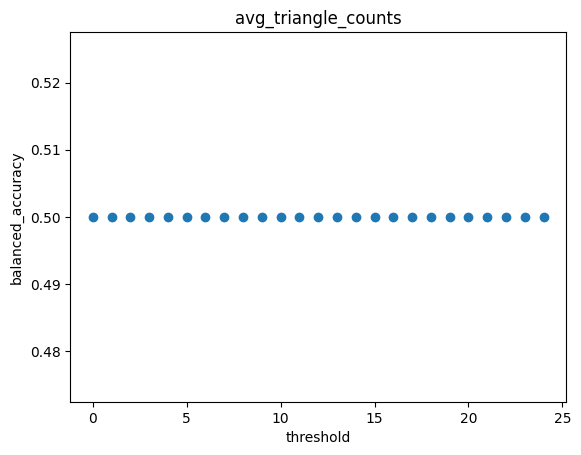

avg_triangle_counts best threshold: 0 best balanced_accuracy: 0.5


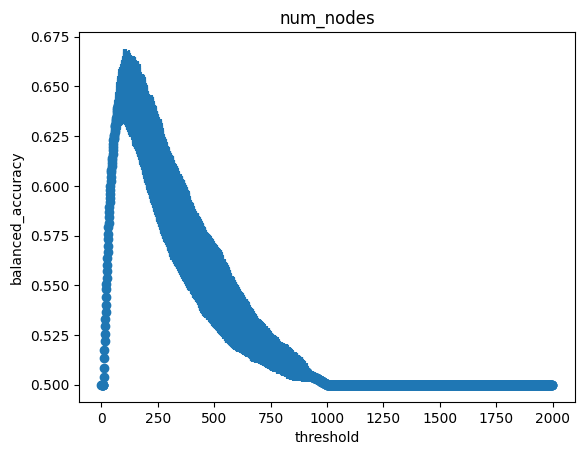

num_nodes best threshold: 102 best balanced_accuracy: 0.6501188635826111


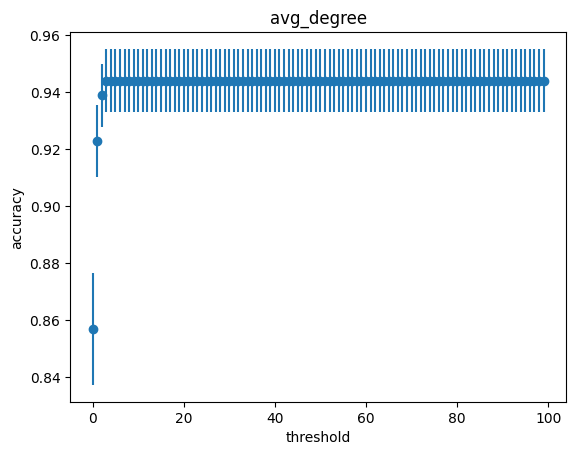

avg_degree best threshold: 4 best accuracy: 0.9440687775611878


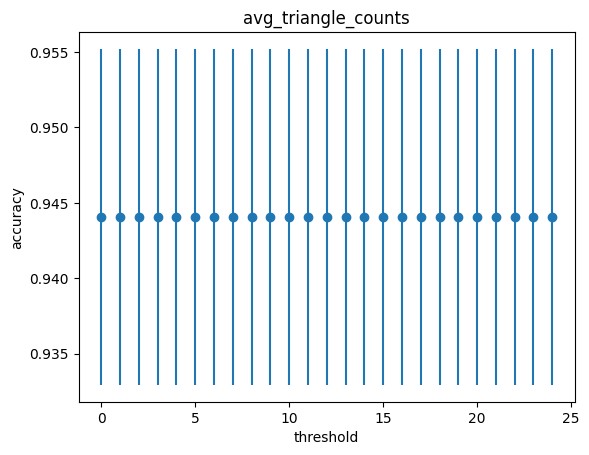

avg_triangle_counts best threshold: 0 best accuracy: 0.9440687775611878


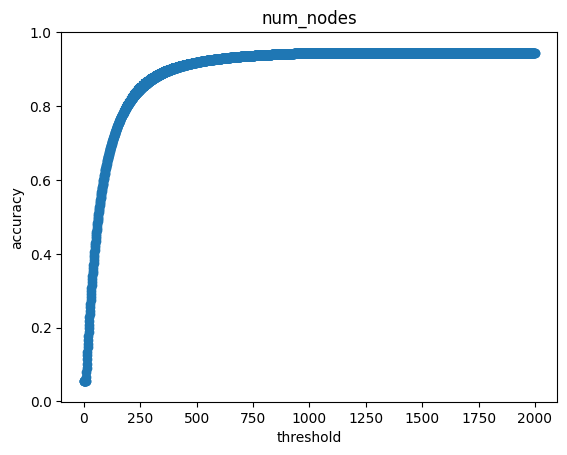

num_nodes best threshold: 1000 best accuracy: 0.9440687775611878


In [57]:
# for each metric name in grouped, plot the threshold vs the metric, include std as error bars in other color

for metric in ['f1', 'precision', 'recall', 'balanced_accuracy', 'accuracy']:
    for metric_name in grouped.index.levels[0]:
        plt.figure()
        plt.errorbar(grouped.loc[metric_name].index, grouped.loc[metric_name][metric], yerr=grouped_std.loc[metric_name][metric], fmt='o')
        plt.title(metric_name)
        plt.xlabel('threshold')
        plt.ylabel(metric)
        plt.show()
        # print out the best threshold for each metric, and the value of the metric at that threshold
        best_threshold = grouped.loc[metric_name][metric].idxmax()
        best_metric = grouped.loc[metric_name][metric].max()
        print(f'{metric_name} best threshold: {best_threshold} best {metric}: {best_metric}')




# final naive predictor, train like other models for comparability

In [5]:
def num_nodes(adj, x, threshold, numn):
    return numn

def avg_degree(adj, x, threshold,numn):
    return torch.mean(torch.sum(adj, dim=2), dim=1)

def avg_triangle_counts(adj, x, threshold,numn):
    return torch.mean(x[:, :, 17], dim=1)  

dict_ = {
    'num_nodes': {'predictor':num_nodes,'threshold_range':[0,2000,1]} ,
    # 'avg_degree': {'predictor':avg_degree,'threshold_range':[0,1000,1, 0.05]} ,
    # 'avg_triangle_counts': {'predictor':avg_triangle_counts,'threshold_range':[0,25,1]}
}

def calc_metrics(y, y_hat):
    TP = torch.sum(y*y_hat)
    FP = torch.sum((1-y)*y_hat)
    FN = torch.sum(y*(1-y_hat))
    TN = torch.sum((1-y)*(1-y_hat))
    
    # check no zeros in denominator
    precision = TP/(TP+FP) if TP+FP != 0 else 0
    recall = TP/(TP+FN) if TP+FN != 0 else 0
    f1 = 2*(precision*recall)/(precision+recall) if precision+recall != 0 else 0
    balanced_accuracy = 0.5*(TP/(TP+FN) + TN/(TN+FP))
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    TOTAL = TP+FP+FN+TN
    return TOTAL, TP, FP, FN, TN, precision, recall, f1, balanced_accuracy, accuracy

import os 
import pandas as pd
# make threhold folder
if not os.path.exists('thresholds'):
    os.makedirs('thresholds')
    
data = [] 
for metric_name, metric in dict_.items():
    
    for i in range(5):
        precomputed_metric, ys = [],[]
        val_dataset = CodeGraphDataset(pt_folder='codegraphs/diversevul/v2_undirected_withdegreecount', DS_type = 'larger10smaller1000', split='val', cross_val_valfold_idx=i, is_cross_val=True is not None, cross_val_val_fraction=1
                        ,remove_degreeandtriangles=False, dense_mode=True)
        
        train_dataset = CodeGraphDataset(pt_folder='codegraphs/diversevul/v2_undirected_withdegreecount', DS_type = 'larger10smaller1000', split='train', cross_val_valfold_idx=i, is_cross_val=True is not None, cross_val_val_fraction=1
                        ,remove_degreeandtriangles=False, dense_mode=True)
        
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
        loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=4)
        for minibatch in tqdm(loader):
            # print(minibatch)
            adj, x,y,numnd = minibatch.adj, minibatch.x, minibatch.y, minibatch.numnodes
            precomputed_y_hat = metric['predictor'](adj, x, 0, numnd)
            precomputed_metric.append(precomputed_y_hat.to(torch.int))
            ys.append(y)
            
        
        ys = torch.cat(ys)
        precomputed_metric = torch.cat(precomputed_metric)
        threhold_data = [] 
        for threshold in range(metric['threshold_range'][0], metric['threshold_range'][1], metric['threshold_range'][2]):
            if len(metric['threshold_range']) == 4:
                threshold = threshold * metric['threshold_range'][3]
                
            # if not os.path.exists(f'thresholds/{metric_name}'):
            #     # make dir 
            #     os.makedirs(f'thresholds/{metric_name}')
            # if not os.path.exists(f'thresholds/{metric_name}/data.csv'):
            #     # make df
            #     df = pd.DataFrame(columns=['threshold', 'min_threshold','max_threshold','fold', 'TOTAL', 'TP', 'FP', 'FN', 'TN', 'precision', 'recall', 'f1', 'balanced_accuracy', 'accuracy'])
            # else: 
            #     df = pd.read_csv(f'thresholds/{metric_name}/data.csv')
                
            # for i in range(5):
                
                
            #     y_hats, ys = [], []
            #     for minibatch in tqdm(loader):
            #         # print(minibatch)
            #         adj, x,y,numnd = minibatch.adj, minibatch.x, minibatch.y, minibatch.numnodes
            #         y_hat = metric['predictor'](adj, x, threshold, numnd)
            #         # y_hat = model(adj, x, threshold)
            #         y_hats.append(y_hat)
            #         ys.append(y)
                
            #     y = torch.cat(ys)
            #     y_hat = torch.cat(y_hats)
            #     y_hat = y_hat.to(torch.int)
            y_hat = precomputed_metric > threshold
            y_hat = y_hat.to(torch.int)
            TOTAL, TP, FP, FN, TN, precision, recall, f1, balanced_accuracy, accuracy = calc_metrics(ys, y_hat)
            TOTAL = TOTAL.item()
            TP, FP, FN, TN = TP.item(), FP.item(), FN.item(), TN.item()
            
            
            precision, recall, f1, balanced_accuracy, accuracy = precision, recall, f1, balanced_accuracy.item(), accuracy.item()
            
            if type(precision) == torch.Tensor:
                precision = precision.item()
            if type(recall) == torch.Tensor:
                recall = recall.item()
            if type(f1) == torch.Tensor:
                f1 = f1.item()
            
            threhold_data.append([threshold, balanced_accuracy])
            
        # choose threshold that maximizes balanced accuracy
        # sort by balanced accuracy
        threhold_data = sorted(threhold_data, key=lambda x: x[1], reverse=True)
        # take threshold that maximizes balanced accuracy
        threshold = threhold_data[0][0]
        # evaluate on val set
        for minibatch in tqdm(val_loader):
            # print(minibatch)
            adj, x,y,numnd = minibatch.adj, minibatch.x, minibatch.y, minibatch.numnodes
            y_hat = metric['predictor'](adj, x, threshold, numnd) > threshold
            y_hat = y_hat.to(torch.int)
            TOTAL, TP, FP, FN, TN, precision, recall, f1, balanced_accuracy, accuracy = calc_metrics(y, y_hat)
            TOTAL = TOTAL.item()
            TP, FP, FN, TN = TP.item(), FP.item(), FN.item(), TN.item()
            
            
            precision, recall, f1, balanced_accuracy, accuracy = precision, recall, f1, balanced_accuracy.item(), accuracy.item()
            
            if type(precision) == torch.Tensor:
                precision = precision.item()
            if type(recall) == torch.Tensor:
                recall = recall.item()
            if type(f1) == torch.Tensor:
                f1 = f1.item()
            
                       
            
            
            # add to df
            # data.append({'threshold' : threshold, 'min_threshold':metric['threshold_range'][0],'max_threshold':metric['threshold_range'][1],'fold':i, 'TOTAL':TOTAL, 'TP':TP, 'FP':FP, 'FN':FN, 'TN':TN, 'precision':precision, 'recall':recall, 'f1':f1, 'balanced_accuracy':balanced_accuracy, 'accuracy':accuracy})
            data.append([metric_name,threshold,metric['threshold_range'][0],metric['threshold_range'][1],i,TOTAL,TP,FP,FN,TN,precision,recall,f1,balanced_accuracy,accuracy])
            
        # save df
        # df.to_csv(f'thresholds/{metric_name}/data.csv', index=False)
        
df = pd.DataFrame(data, columns=['metric_name','threshold', 'min_threshold','max_threshold','fold', 'TOTAL', 'TP', 'FP', 'FN', 'TN', 'precision', 'recall', 'f1', 'balanced_accuracy', 'accuracy'])
df.to_csv(f'thresholds/baseline.csv', index=False)


Split 0: 31514
Split 1: 37095
Split 2: 62861
Split 3: 44591
Split 4: 28496


Processing...
Done!


Split 0: 31514
Split 1: 37095
Split 2: 62861
Split 3: 44591
Split 4: 28496


Processing...
Done!
/home/amos/mambaforge/envs/pyg/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
  2%|▏         | 84/5408 [00:52<55:47,  1.59it/s]  


KeyboardInterrupt: 